# MSDS 7331 - Lab 3 - Airline Satisfaction Dataset
***
Team - Triston Hudgins, Shijo Joseph, Douglas Yip

#### The dataset chosen is a compilation of airline customer satisfaction surveys.  The goal is to select from one of features (Association Rule Mining, Clustering, or Collaborative Filtering) to build a classifier and analyze its performance in terms of accuracy (precision, recall) and speed) to help us understand the customer sastification. 

Source: https://www.kaggle.com/datasets/teejmahal20/airline-passenger-satisfaction?resource=download&select=test.csv

In [190]:
## Setup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
%matplotlib inline
import seaborn as sns
import plotly.express as px
import scipy.stats as stats

# Import Cluster Analysis libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, normalize
from sklearn.preprocessing import MinMaxScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn import metrics
import scipy.cluster.hierarchy as sch

#import visualization libraries
from matplotlib.pyplot import scatter
import plotly
from plotly.graph_objs import Scatter, Marker, Layout, layout,XAxis, YAxis, Bar, Line
%matplotlib inline

# get ANOVA table as R like output
import statsmodels.api as sm
from statsmodels.formula.api import ols

***
### Data Understanding (20 points total)
### [10 points] Describe the meaning and type of data (scale, values, etc.) for each attribute in the data file. Verify data quality: Are there missing values? Duplicate data? Outliers? Are those mistakes? How do you deal with these problems?

In [191]:
# load the airline satisfaction  dataset

df = pd.read_csv('https://raw.githubusercontent.com/dk28yip/MSDS7331/main/airline.csv') # read in the csv file
df.head()

#reduced samples set from 100,000 to 30,000 as a few of us had computer performance issues
df = df.sample(n=30000)

#### Check for NAs


In [192]:
# Any missing values in the dataset
def plot_missingness(df: pd.DataFrame=df) -> None:
    nan_df = pd.DataFrame(df.isna().sum()).reset_index()
    nan_df.columns  = ['Column', 'NaN_Count']
    nan_df['NaN_Count'] = nan_df['NaN_Count'].astype('int')
    nan_df['NaN_%'] = round(nan_df['NaN_Count']/df.shape[0] * 100,4)
    nan_df['Type']  = 'Missingness'
    nan_df.sort_values('NaN_%', inplace=True)

    # Add completeness
    for i in range(nan_df.shape[0]):
        complete_df = pd.DataFrame([nan_df.loc[i,'Column'],df.shape[0] - nan_df.loc[i,'NaN_Count'],100 - nan_df.loc[i,'NaN_%'], 'Completeness']).T
        complete_df.columns  = ['Column','NaN_Count','NaN_%','Type']
        complete_df['NaN_%'] = complete_df['NaN_%'].astype('int')
        complete_df['NaN_Count'] = complete_df['NaN_Count'].astype('int')
        nan_df = pd.concat([nan_df,complete_df], sort=True)
            
    nan_df = nan_df.rename(columns={"Column": "Feature", "NaN_%": "Missing %"})

    # Missingness Plot
    fig = px.bar(nan_df,
                 x='Feature',
                 y='Missing %',
                 title=f"Missingness Plot (N={df.shape[0]})",
                 color='Type',
                 opacity = 0.6,
                 color_discrete_sequence=['red','#808080'],
                 width=800,
                 height=800)
    fig.show()

plot_missingness(df)

print("Missing 99 values if the 'Arrival Delay in Minutes'column; approximately 0.31%.")

Missing 99 values if the 'Arrival Delay in Minutes'column; approximately 0.31%.


#### Remove unwanted columns
ID was removed from the dataset as it was used as a unique identified for each passenger

In [193]:
df["GenderNumeric"] = (df["Gender"]=="Male").astype(int)
df["CustomerTypeNumeric"] = (df["Customer Type"]=="Loyal Customer").astype(int)
df["TypeofTravelNumeric"] = (df["Type of Travel"]=="Personal Travel").astype(int)
df["ClassNumeric"] = df["Class"]
df["ClassNumeric"].replace(['Eco', 'Eco Plus', 'Business'], [0, 1, 2], inplace=True)

df["Arrival Delay in Minutes"]= df["Arrival Delay in Minutes"].fillna(0)


dfclean = df.drop(columns=['id'])

dfclean.isnull().sum() #double check on the missing values - 'arrival delay in minutes =310'

Gender                               0
Customer Type                        0
Age                                  0
Type of Travel                       0
Class                                0
Flight Distance                      0
Inflight wifi service                0
Departure/Arrival time convenient    0
Ease of Online booking               0
Gate location                        0
Food and drink                       0
Online boarding                      0
Seat comfort                         0
Inflight entertainment               0
On-board service                     0
Leg room service                     0
Baggage handling                     0
Checkin service                      0
Inflight service                     0
Cleanliness                          0
Departure Delay in Minutes           0
Arrival Delay in Minutes             0
satisfaction                         0
GenderNumeric                        0
CustomerTypeNumeric                  0
TypeofTravelNumeric      

In [194]:
#Fill in missing values
dfclean["Arrival Delay in Minutes"].fillna(dfclean["Arrival Delay in Minutes"].median(), inplace=True)

In [195]:
dfclean.describe().T

count         mean         std   min  \
Age                                30000.0    39.414167   15.083985   7.0   
Flight Distance                    30000.0  1192.047800  994.998027  31.0   
Inflight wifi service              30000.0     2.735133    1.328597   0.0   
Departure/Arrival time convenient  30000.0     3.053533    1.523552   0.0   
Ease of Online booking             30000.0     2.754467    1.396249   0.0   
Gate location                      30000.0     2.981367    1.276273   0.0   
Food and drink                     30000.0     3.210767    1.329462   0.0   
Online boarding                    30000.0     3.263600    1.346666   0.0   
Seat comfort                       30000.0     3.449167    1.319775   1.0   
Inflight entertainment             30000.0     3.367233    1.332128   0.0   
On-board service                   30000.0     3.384667    1.285206   0.0   
Leg room service                   30000.0     3.361267    1.316717   0.0   
Baggage handling                   30000.0     3.638033    1.175752   1.0   
Checkin service                    30000.0     3.305233    1.261396   1.0   
Inflight service                   30000.0     3.648267    1.169386   0.0   
Cleanliness                        30000.0     3.290967    1.311473   0.0   
Departure Delay in Minutes         30000.0    14.582000   36.776830   0.0   
Arrival Delay in Minutes           30000.0    14.887433   37.155818   0.0   
GenderNumeric                      30000.0     0.490900    0.499926   0.0   
CustomerTypeNumeric                30000.0     0.817967    0.385878   0.0   
TypeofTravelNumeric                30000.0     0.307967    0.461660   0.0   
ClassNumeric                       30000.0     1.037367    0.963709   0.0   

                                     25%    50%     75%     max  
Age                                 27.0   40.0    51.0    85.0  
Flight Distance                    414.0  852.0  1739.0  4983.0  
Inflight wifi service                2.0    3.0     4.0     5.0  
Departure/Arrival time convenient    2.0    3.0     4.0     5.0  
Ease of Online booking               2.0    3.0     4.0     5.0  
Gate location                        2.0    3.0     4.0     5.0  
Food and drink                       2.0    3.0     4.0     5.0  
Online boarding                      2.0    3.0     4.0     5.0  
Seat comfort                         2.0    4.0     5.0     5.0  
Inflight entertainment               2.0    4.0     4.0     5.0  
On-board service                     2.0    4.0     4.0     5.0  
Leg room service                     2.0    4.0     4.0     5.0  
Baggage handling                     3.0    4.0     5.0     5.0  
Checkin service                      3.0    3.0     4.0     5.0  
Inflight service                     3.0    4.0     5.0     5.0  
Cleanliness                          2.0    3.0     4.0     5.0  
Departure Delay in Minutes           0.0    0.0    12.0   978.0  
Arrival Delay in Minutes             0.0    0.0    13.0   970.0  
GenderNumeric                        0.0    0.0     1.0     1.0  
CustomerTypeNumeric                  1.0    1.0     1.0     1.0  
TypeofTravelNumeric                  0.0    0.0     1.0     1.0  
ClassNumeric                         0.0    1.0     2.0     2.0

In [196]:
dfclean.corr()

Age  Flight Distance  \
Age                                1.000000         0.095188   
Flight Distance                    0.095188         1.000000   
Inflight wifi service              0.018478         0.013954   
Departure/Arrival time convenient  0.037307        -0.012719   
Ease of Online booking             0.020803         0.072714   
Gate location                     -0.001885         0.011645   
Food and drink                     0.018272         0.055558   
Online boarding                    0.207244         0.215446   
Seat comfort                       0.156468         0.155785   
Inflight entertainment             0.078724         0.130765   
On-board service                   0.068147         0.109308   
Leg room service                   0.043644         0.134958   
Baggage handling                  -0.039333         0.067021   
Checkin service                    0.045725         0.079698   
Inflight service                  -0.037263         0.056714   
Cleanliness                        0.049894         0.093740   
Departure Delay in Minutes        -0.007250         0.002220   
Arrival Delay in Minutes          -0.008015        -0.001368   
GenderNumeric                      0.016120         0.008361   
CustomerTypeNumeric                0.280152         0.223103   
TypeofTravelNumeric               -0.044506        -0.270812   
ClassNumeric                       0.138785         0.452400   

                                   Inflight wifi service  \
Age                                             0.018478   
Flight Distance                                 0.013954   
Inflight wifi service                           1.000000   
Departure/Arrival time convenient               0.343299   
Ease of Online booking                          0.719087   
Gate location                                   0.347900   
Food and drink                                  0.137952   
Online boarding                                 0.453773   
Seat comfort                                    0.123191   
Inflight entertainment                          0.203959   
On-board service                                0.117105   
Leg room service                                0.159044   
Baggage handling                                0.113138   
Checkin service                                 0.043628   
Inflight service                                0.106337   
Cleanliness                                     0.128408   
Departure Delay in Minutes                     -0.022472   
Arrival Delay in Minutes                       -0.023811   
GenderNumeric                                   0.011979   
CustomerTypeNumeric                             0.008619   
TypeofTravelNumeric                            -0.104341   
ClassNumeric                                    0.036342   

                                   Departure/Arrival time convenient  \
Age                                                         0.037307   
Flight Distance                                            -0.012719   
Inflight wifi service                                       0.343299   
Departure/Arrival time convenient                           1.000000   
Ease of Online booking                                      0.436748   
Gate location                                               0.445174   
Food and drink                                              0.004008   
Online boarding                                             0.068330   
Seat comfort                                                0.013041   
Inflight entertainment                                     -0.006533   
On-board service                                            0.067436   
Leg room service                                            0.005314   
Baggage handling                                            0.061936   
Checkin service                                             0.097096   
Inflight service                                            0.065876   
Cleanliness                       

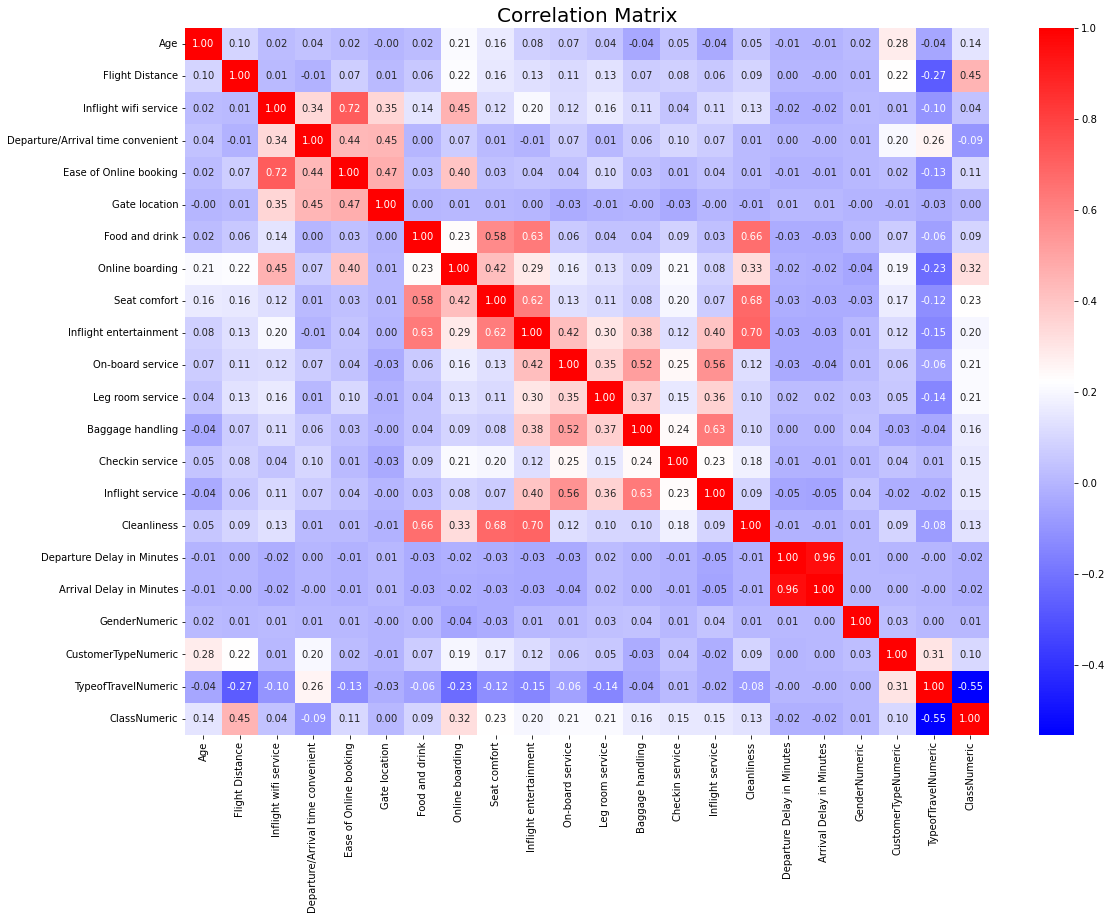

In [197]:
f, ax = plt.subplots(figsize=[18, 13])
sns.heatmap(dfclean.corr(), annot=True, fmt=".2f", ax=ax, cmap="bwr")
ax.set_title("Correlation Matrix", fontsize=20)
plt.show()

Very strong correlations (values from 0.8 to 1 or -0.8 to -1.0)
Strong correlations (values from 0.6 to 0.8 or -0.6 to -0.8)
Moderate correlations (values from 0.4 to 0.6 or -0.4 to -0.6) 

#### Check distribution of the data

C:\Users\thud1\anaconda3\envs\ML7331\lib\site-packages\seaborn\axisgrid.py:409: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



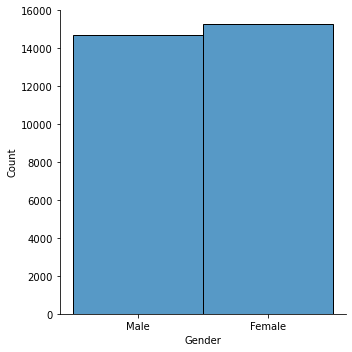

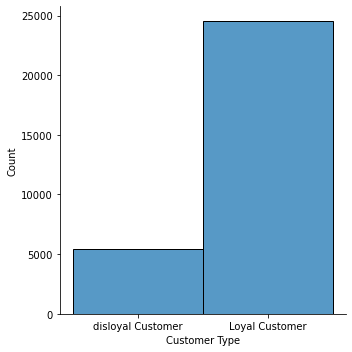

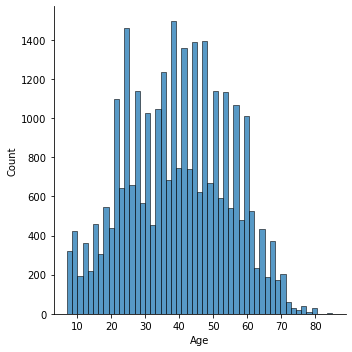

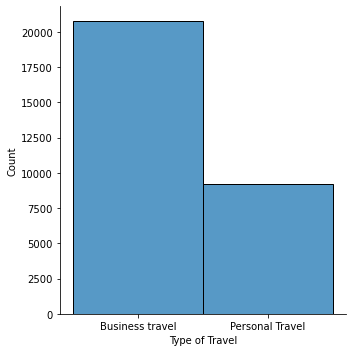

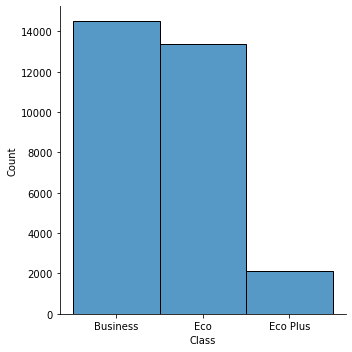

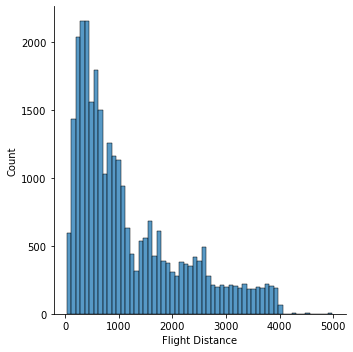

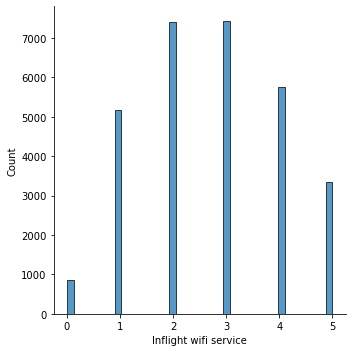

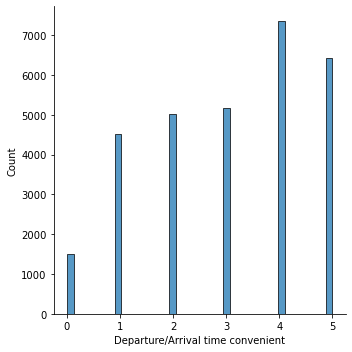

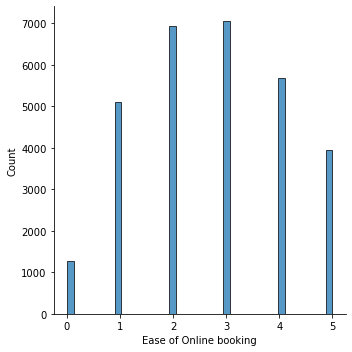

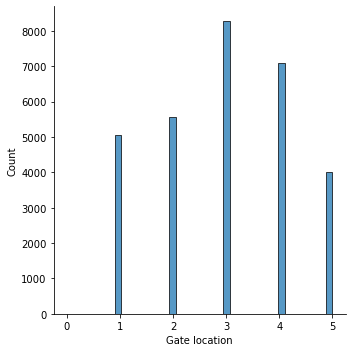

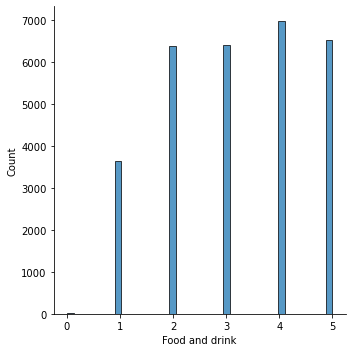

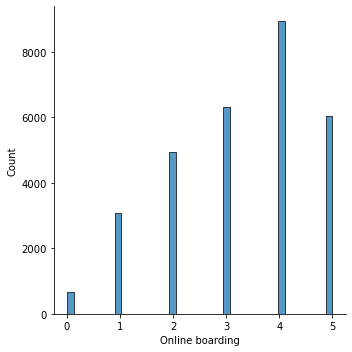

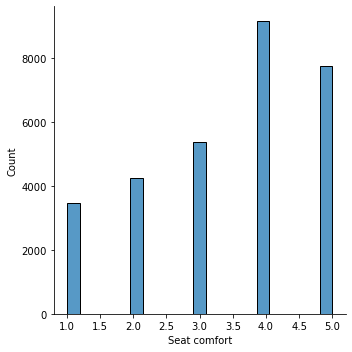

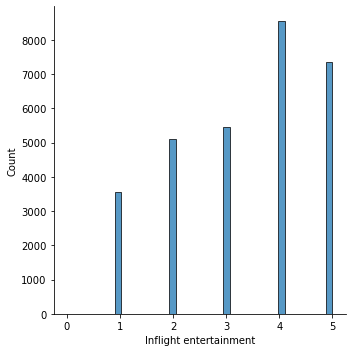

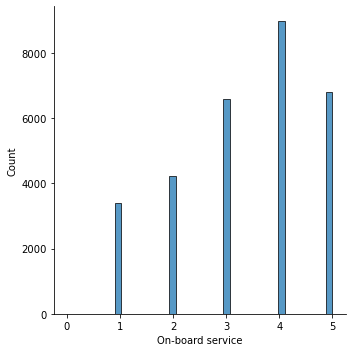

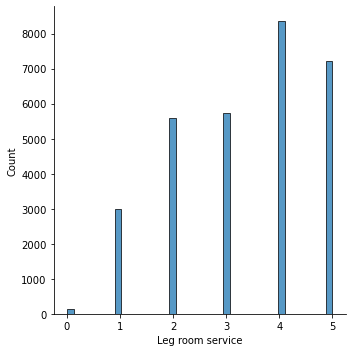

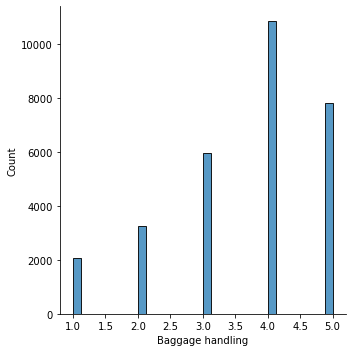

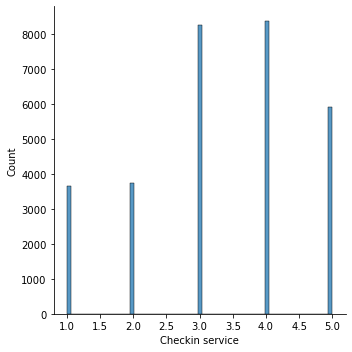

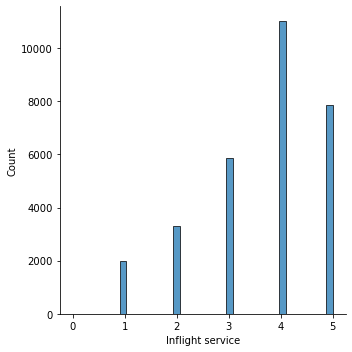

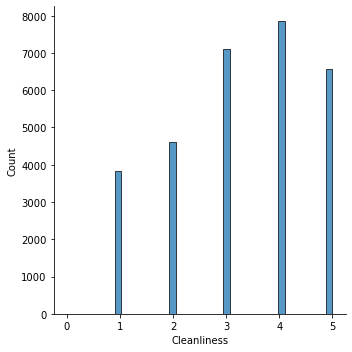

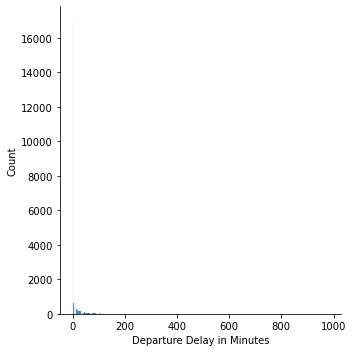

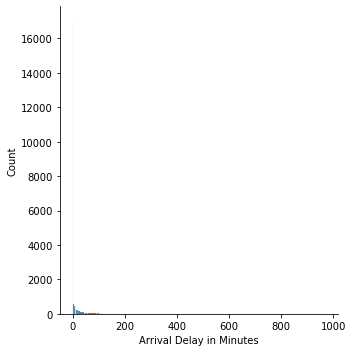

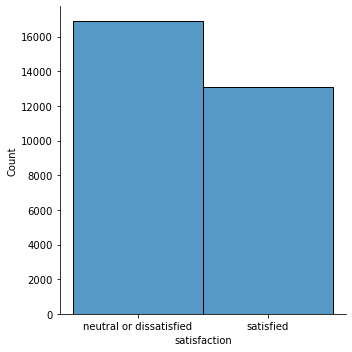

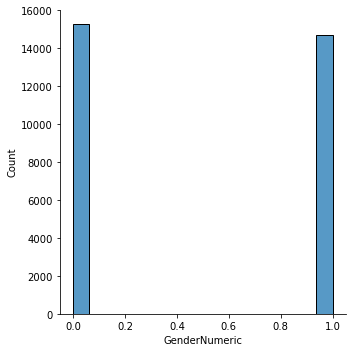

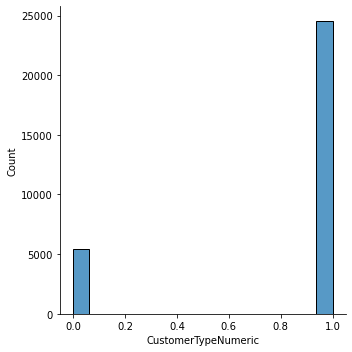

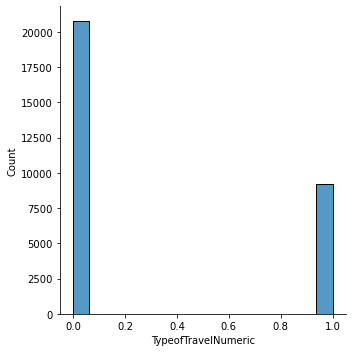

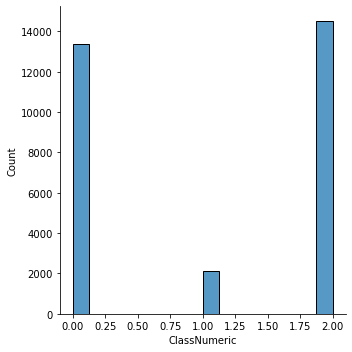

In [198]:
##distribution of the data

for column in dfclean:
    
    sns.displot(x=column, data=dfclean)

In [199]:
print (dfclean.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 30599 to 83337
Data columns (total 27 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Gender                             30000 non-null  object 
 1   Customer Type                      30000 non-null  object 
 2   Age                                30000 non-null  int64  
 3   Type of Travel                     30000 non-null  object 
 4   Class                              30000 non-null  object 
 5   Flight Distance                    30000 non-null  int64  
 6   Inflight wifi service              30000 non-null  int64  
 7   Departure/Arrival time convenient  30000 non-null  int64  
 8   Ease of Online booking             30000 non-null  int64  
 9   Gate location                      30000 non-null  int64  
 10  Food and drink                     30000 non-null  int64  
 11  Online boarding                    30000 non-null 

#### Summary of values to be used in classification modeling
A total of +100,000 passenger results are recorded in this data set.
We have a combination of categorical, ordinal and continous variable in this dataset.

- __Gender:__- Gender of the passengers (Female, Male) - Categorical Variable
- __Customer Type:__- The customer type (Loyal customer, disloyal customer) - Categorical Variable
- __Age:__- The actual age of the passengers - Continous Variable
- __Type of Travel:__- Purpose of the flight of the passengers (Personal Travel, Business Travel) - Categorical Variable
- __Class:__- Travel class in the plane of the passengers (Business, Eco, Eco Plus) - Categorical Variable
- __Flight distance:__- The flight distance of this journey - Continous Variable
- __Inflight wifi service:__- Satisfaction level of the inflight wifi service (0:Not Applicable;1-5) - Categorical Variable
- __Departure/Arrival time convenient:__- Satisfaction level of Departure/Arrival time convenient - Categorical Variable
- __Ease of Online booking:__- Satisfaction level of online booking - Categorical Variable
- __Gate location:__- Satisfaction level of Gate location - Categorical Variable
- __Food and drink:__- Satisfaction level of Food and drink - Categorical Variable
- __Online boarding:__- Satisfaction level of online boarding - Categorical Variable
- __Seat comfort:__- Satisfaction level of Seat comfort - Categorical Variable
- __Inflight entertainment:__- Satisfaction level of inflight entertainment - Categorical Variable
- __On-board service:__- Satisfaction level of On-board service - Categorical Variable
- __Leg room service:__- Satisfaction level of Leg room service - Categorical Variable
- __Baggage handling:__- Satisfaction level of baggage handling - Categorical Variable
- __Check-in service:__- Satisfaction level of Check-in service - Categorical Variable
- __Inflight service:__- Satisfaction level of inflight service - Categorical Variable
- __Cleanliness:__- Satisfaction level of Cleanliness - Categorical Variable
- __Departure Delay in Minutes:__- Minutes delayed when departure - Continous Variable
- __Arrival Delay in Minutes:__- Minutes delayed when Arrival - Continous Variable
- __Satisfaction:__- Airline satisfaction level(Satisfaction, neutral or dissatisfaction) - Categorical Variable

*** 
### [10 points] Visualize the any important attributes appropriately. Important: Provide an interpretation for any charts or graphs.

##### Differences between avg score between business and economy - two-sided t test
##### Random BS Graphs
##### ANOVA on Age

In [200]:
 #Sum Survey Score Columns - index(6:19)
dfclean['Total']=dfclean.iloc[:,6:19].sum(axis=1)

#Add Age Groups
dfclean['Age_Group'] = pd.cut(dfclean['Age'], bins = [0,17,35,65,90], labels=["Adolescent", "Young Adult", "Middle Age", "Senior"], right=True)
dfclean['Age_Group_Numeric'] = pd.cut(dfclean['Age'], bins = [0,17,35,65,90], labels=["1", "2", "3", "4"], right=True)

#Add Distance Groups
dfclean['Distance_Group'] = pd.cut(dfclean['Flight Distance'], bins = [0,500,1000,2500,5000], labels=["Short", "Moderate", "Long", "Extra Long"], right=True)
dfclean['Distance_Group_Numeric'] = pd.cut(dfclean['Flight Distance'], bins = [0,500,1000,2500,5000], labels=["1", "2", "3", "4"], right=True)

#Add Departure Delay Groups
dfclean['Departure_Delay_Group'] = pd.cut(dfclean['Departure Delay in Minutes'], bins = [-1,1,100,1600], labels=["None","Minimal","Long"], right=True)
dfclean['Departure_Delay_Group_Numeric'] = pd.cut(dfclean['Departure Delay in Minutes'], bins = [-1,1,100,1600], labels=["0","1","2"], right=True)


dfclean.head(n=50)

Gender      Customer Type  Age   Type of Travel     Class  \
30599     Male  disloyal Customer   38  Business travel  Business   
47873     Male     Loyal Customer   46  Personal Travel       Eco   
20019   Female     Loyal Customer   61  Personal Travel  Eco Plus   
38169     Male     Loyal Customer   59  Business travel  Business   
31261     Male     Loyal Customer   30  Business travel  Business   
61174     Male     Loyal Customer   41  Personal Travel       Eco   
80636   Female     Loyal Customer   47  Business travel  Business   
95738     Male     Loyal Customer   49  Business travel  Business   
36906   Female  disloyal Customer   23  Business travel       Eco   
75815     Male     Loyal Customer   40  Business travel  Business   
81361   Female     Loyal Customer   67  Personal Travel  Eco Plus   
91192     Male     Loyal Customer   20  Personal Travel       Eco   
60215   Female     Loyal Customer   31  Personal Travel       Eco   
76209   Female     Loyal Customer   38  Personal Travel       Eco   
80791   Female     Loyal Customer   63  Business travel       Eco   
527       Male     Loyal Customer   19  Personal Travel       Eco   
27773   Female     Loyal Customer   57  Business travel  Business   
40038     Male  disloyal Customer   30  Business travel       Eco   
40029   Female     Loyal Customer   28  Business travel       Eco   
102585  Female     Loyal Customer   27  Personal Travel       Eco   
11339     Male     Loyal Customer   34  Business travel  Business   
88869   Female     Loyal Customer   19  Personal Travel       Eco   
101509  Female     Loyal Customer   50  Personal Travel       Eco   
96697     Male     Loyal Customer   35  Business travel       Eco   
59108   Female     Loyal Customer   44  Business travel  Business   
96744   Female  disloyal Customer   29  Business travel       Eco   
71964     Male     Loyal Customer   64  Personal Travel       Eco   
100522    Male     Loyal Customer   26  Personal Travel       Eco   
103357  Female     Loyal Customer   44  Business travel  Business   
44318   Female     Loyal Customer   50  Personal Travel       Eco   
55590     Male  disloyal Customer   21  Business travel       Eco   
77495   Female     Loyal Customer   30  Business travel  Business   
95617   Female  disloyal Customer   25  Business travel  Business   
54928     Male     Loyal Customer   28  Personal Travel  Business   
7503    Female     Loyal Customer   42  Business travel  Business   
97944     Male     Loyal Customer   22  Personal Travel       Eco   
51547   Female     Loyal Customer    8  Personal Travel       Eco   
46453   Female     Loyal Customer   44  Personal Travel       Eco   
13989   Female  disloyal Customer   39  Business travel  Business   
43812     Male     Loyal Customer   13  Personal Travel       Eco   
42685     Male     Loyal Customer   26  Business travel  Business   
43547   Female     Loyal Customer   73  Business travel  Business   
39690   Female     Loyal Customer   55  Business travel  Business   
79649   Female     Loyal Customer   35  Business travel  Business   
17258     Male     Loyal Customer   34  Business travel  Business   
16596     Male     Loyal Customer   25  Personal Travel       Eco   
2592    Female  disloyal Customer   38  Business travel  Business   
16590   Female     Loyal Customer   34  Personal Travel       Eco   
14040   Female     Loyal Customer   47  Business travel  Business   
82174     Male     Loyal Customer   62  Business travel  Business   

        Flight Distance  Inflight wifi service  \
30599              1670                      3   
47873               813                      2   
20019              2402                      1   
38169               821                      4   
31261              2212                      4   
61174               337                      4   
80636               234                      0   
95738               405                      4   
36906              2454               

In [201]:
#Plotly Histogram - Age
px.histogram(dfclean['Age'], x= "Age",
             title = 'Age Distribution',
             )

In [202]:
#Plotly Histogram - Flight Distance
px.histogram(dfclean['Flight Distance'], x= "Flight Distance",
             title = 'Flight Distance Distribution',
             )

In [203]:
#Plotly Histogram - Departure Delay in Minutes
px.histogram(dfclean['Departure Delay in Minutes'], x= "Departure Delay in Minutes",
             title = 'Departure Delay Distribution',
             nbins = 50,
             )

In [204]:
#Plotly Histogram - Arrival Delay in Minutes
px.histogram(dfclean['Arrival Delay in Minutes'], x= "Arrival Delay in Minutes",
             title = 'Arrival Delay Distribution',
             nbins = 50,
             )

In [205]:
px.box(dfclean,
       x="Class", y="Age", 
       color="Class",
       title = "Box Plot of Age by Class")

In [206]:
#ANOVA of class to age
# Ordinary Least Squares (OLS) model
model = ols('Age ~ C(Class)', data=dfclean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq       df           F         PR(>F)
C(Class)  1.318185e+05      2.0  295.361868  9.389981e-128
Residual  6.693753e+06  29997.0         NaN            NaN

In [207]:
#ANOVA of class to Total Survey Score
# Ordinary Least Squares (OLS) model
model = ols('Total ~ C(Age)', data=dfclean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq       df          F         PR(>F)
C(Age)    7.592085e+04     74.0  14.478122  3.892880e-173
Residual  2.120563e+06  29925.0        NaN            NaN

In [208]:
#ANOVA of age to Total Survey Score
# Ordinary Least Squares (OLS) model
model = ols('Total ~ C(Class)', data=dfclean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq       df            F  PR(>F)
C(Class)  1.659126e+05      2.0  1225.487267     0.0
Residual  2.030572e+06  29997.0          NaN     NaN

In [210]:
px.box(dfclean,
       x="Distance_Group", y="Total", 
       color="Distance_Group",
       title = "Box Plot of Age by Class")

In [211]:
px.box(dfclean,
       x="Departure_Delay_Group", y="Total", 
       color="Departure_Delay_Group",
       title = "Box Plot of Total by Departure Delay Group")

In [212]:
#ANOVA of age to Total Survey Score
# Ordinary Least Squares (OLS) model
model = ols('Total ~ C(Departure_Delay_Group)', data=dfclean).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
anova_table

sum_sq       df          F        PR(>F)
C(Departure_Delay_Group)  2.086182e+03      2.0  14.258857  6.462474e-07
Residual                  2.194398e+06  29997.0        NaN           NaN

Triston to group flight delays to create anova
gender 2 sample t test
reorganize data.
triston to make satifacation to numeric
total to survey_total_score

***
### Modeling and Evaluation (50 points total) Different tasks will require different evaluation methods. Be as thorough as possible when analyzing the data you have chosen and use visualizations of the results to explain the performance and expected outcomes whenever possible. Guide the reader through your analysis with plenty of discussion of the results. 



#### Option A: Cluster Analysis
- Perform cluster analysis using several clustering methods
- How did you determine a suitable number of clusters for each method?
- Use internal and/or external validation measures to describe and compare the clusterings and the clusters (some visual methods would be good).
- Describe your results. What findings are the most interesting and why?

In [21]:
#set data to be ready for cluster analysis
cluster_df = dfclean.copy()

continuous_features = ['Flight Distance','Departure Delay in Minutes','Arrival Delay in Minutes']

# and the oridnal values to be integers
ordinal_features = ['Age','Inflight wifi service','Departure/Arrival time convenient']

# we won't touch these variables, keep them as categorical
categ_features = ['GenderNumeric','TypeofTravelNumeric','CustomerTypeNumeric'];

# use the "astype" function to change the variable type
cluster_df[continuous_features] = cluster_df[continuous_features].astype(np.float64)
cluster_df[ordinal_features] = cluster_df[ordinal_features].astype(np.int64)
cluster_df = cluster_df.drop(['Age Group','Distance Group','Gender','Customer Type','Type of Travel', 'Class','satisfaction'], axis=1)


cluster_df.info() # now our data looks better!!

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30000 entries, 41661 to 39875
Data columns (total 23 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   Age                                30000 non-null  int64  
 1   Flight Distance                    30000 non-null  float64
 2   Inflight wifi service              30000 non-null  int64  
 3   Departure/Arrival time convenient  30000 non-null  int64  
 4   Ease of Online booking             30000 non-null  int64  
 5   Gate location                      30000 non-null  int64  
 6   Food and drink                     30000 non-null  int64  
 7   Online boarding                    30000 non-null  int64  
 8   Seat comfort                       30000 non-null  int64  
 9   Inflight entertainment             30000 non-null  int64  
 10  On-board service                   30000 non-null  int64  
 11  Leg room service                   30000 non-null 

In [22]:
#scale values
cluster_df_scaled = StandardScaler().fit(cluster_df).transform(cluster_df.astype(float))

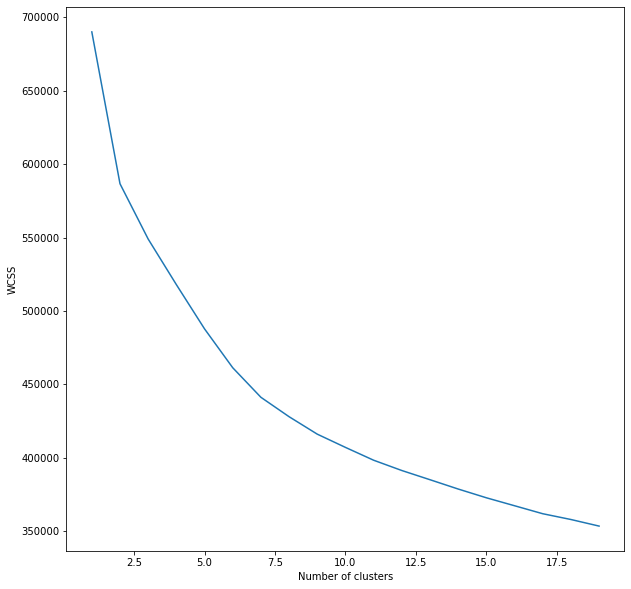

In [23]:
# finding optimal cluster amount
wcss = []
for i in range(1,20):
   model = KMeans(n_clusters = i, init = "k-means++", random_state=67)
   model.fit(cluster_df_scaled)
   wcss.append(model.inertia_)
plt.figure(figsize=(10,10))
plt.plot(range(1,20), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [24]:
# reducing dimensionality
pca = PCA(2)
data = pca.fit_transform(cluster_df_scaled)
data

array([[-0.09704676, -0.14432955],
       [-0.76629842,  3.02484519],
       [-1.93995507,  1.06308126],
       ...,
       [-2.13104933, -2.27874364],
       [-3.10395854, -1.04380683],
       [ 3.02882386, -0.43075345]])

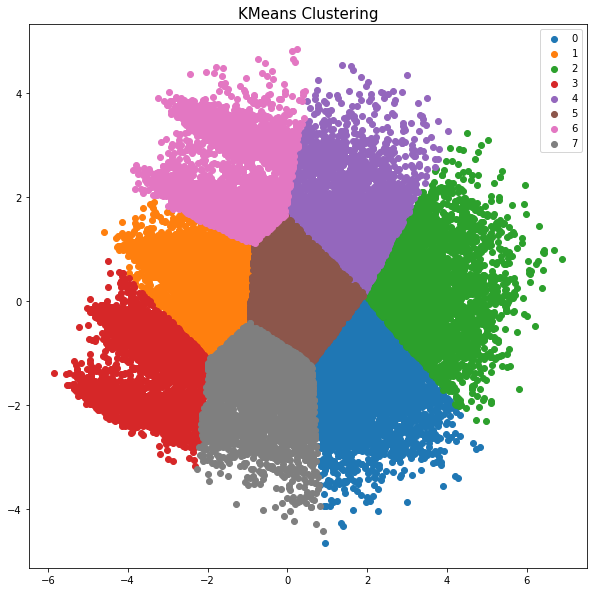

In [25]:
# clustering with PCA components

model = KMeans(n_clusters = 8, init = "k-means++")
label = model.fit_predict(data)


plt.figure(figsize=(10,10))
uniq = np.unique(label)
for i in uniq:
   plt.scatter(data[label == i , 0] , data[label == i , 1] , label = i)


plt.legend()
plt.title('KMeans Clustering', fontsize=15)
plt.show()

In [26]:
metrics.silhouette_score(cluster_df_scaled, label)

0.04945206697650716

### DBSCAN Clustering

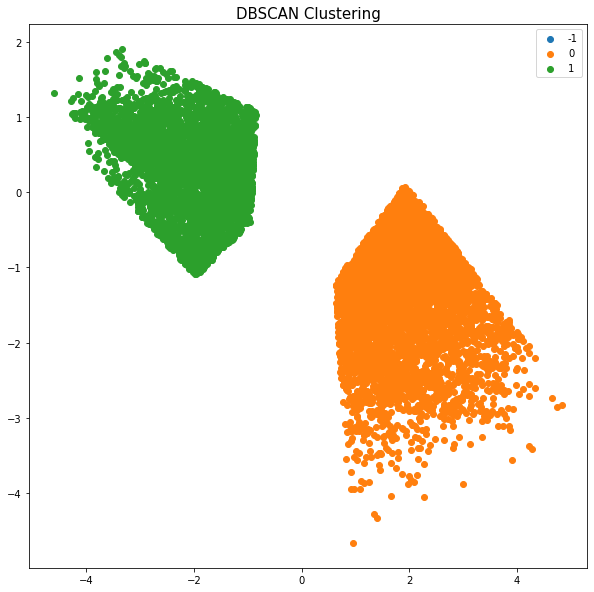

In [35]:
# clustering with PCA components

dbscan = DBSCAN(eps=0.3)
dbscan_label = dbscan.fit_predict(data)

plt.figure(figsize=(10,10))
uniq = np.unique(dbscan_label)
for i in uniq:
   plt.scatter(data[label == i , 0] , data[label == i , 1] , label = i)


plt.legend()
plt.title('DBSCAN Clustering', fontsize=15)
plt.show()

In [36]:
metrics.silhouette_score(cluster_df_scaled, dbscan_label)

0.15017256646052127

#### Hierarchical Agglomerative Clustering (HAC) Clustering

In [29]:
# utilizing a dendrogram to find the optimal number of clusters

#dendrogram = sch.dendrogram(sch.linkage(data, method='ward'))
#plt.title('Dendrogram')
#plt.show()

In [30]:
# hac = AgglomerativeClustering(n_clusters=3, affinity='euclidean',linkage='ward')
# hac_label = hac.fit_predict(data)

# plt.figure(figsize=(10,10))
# uniq = np.unique(hac_label)
# for i in uniq:
#    plt.scatter(data[label == i , 0] , data[label == i , 1] , label = i)


# plt.legend()
# plt.title('HAC Clustering', fontsize=15)
# plt.show()

In [31]:
# metrics.silhouette_score(cluster_df_scaled, hac_label)

In [32]:
# result_df = df.copy()
# result_df['kmeans_cluster'] = label
# result_df['dbscan_cluster'] = dbscan_label
# result_df['hac_cluster'] = hac_label
# result_df.info()

### Deployment (10 points total)
- Be critical of your performance and tell the reader how you current model might be usable by
other parties. Did you achieve your goals? If not, can you reign in the utility of your modeling?
- How useful is your model for interested parties (i.e., the companies or organizations
that might want to use it)?
- How would your deploy your model for interested parties?
- What other data should be collected?
- How often would the model need to be updated, etc.?

Doug to Bull shit

### Exceptional Work (10 points total)
You have free reign to provide additional analyses or combine analyses

In [34]:
#Exception work above.